In [1]:
# functions defined in previous notebooks
from utils import *

ModuleNotFoundError: No module named 'torch'

In [7]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [8]:
(...,) + (None,) * 2

(Ellipsis, None, None)

In [9]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalEmbedding(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  62438883


Files already downloaded and verified


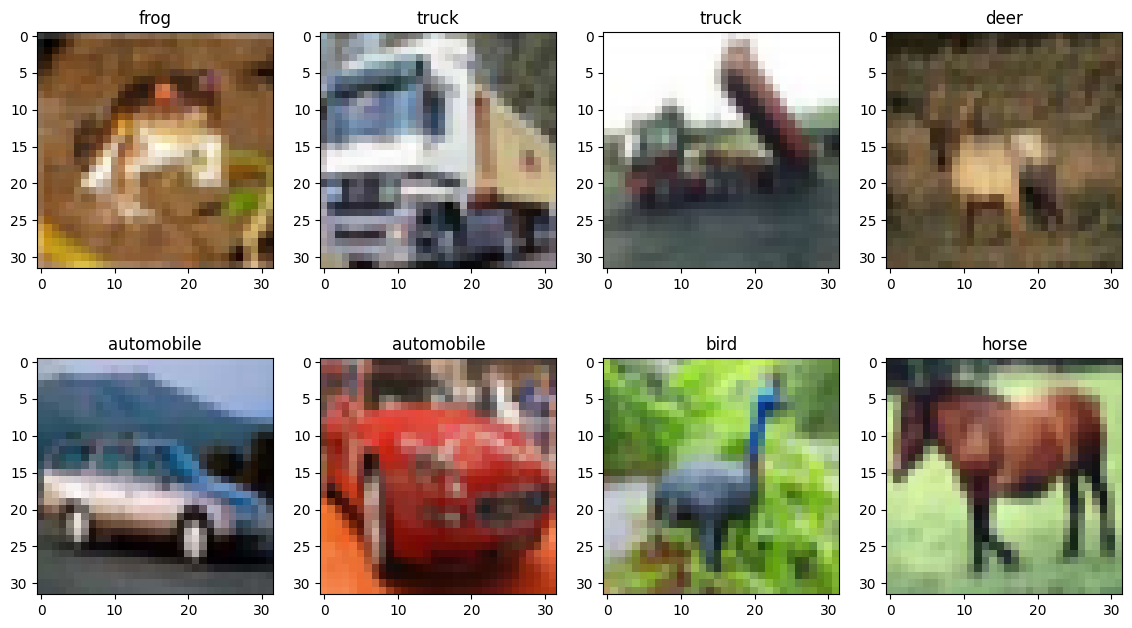

In [10]:
# only prints displays the images
data_path = '../data-unversioned/p1ch10/'

def show_images(data, num_samples=12, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(14, 12)) 
    for i, (img, label) in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.title(data.classes[label])
        plt.imshow(img)

data = torchvision.datasets.CIFAR10(data_path, download=True)
show_images(data, num_samples=8)

In [14]:
transform = torchvision.transforms.ToTensor()
sample, target = data[0]
print(sample, target)
transform(sample).shape

tensor([[[ 0.1608,  0.1922,  0.2392,  ..., -0.6078, -0.6627, -0.5373],
         [-0.0431, -0.0667, -0.0353,  ..., -0.8588, -1.0000, -0.8745],
         [-0.1451, -0.0588, -0.0745,  ..., -0.6157, -0.8745, -0.8039],
         ...,
         [-0.5843, -0.5608,  0.2549,  ...,  0.5529,  0.5765,  0.6314],
         [-0.3490, -0.2392,  0.4431,  ...,  0.4588,  0.3569,  0.4118],
         [-0.0353,  0.1843,  0.6941,  ...,  0.4039,  0.3176,  0.3882]],

        [[-0.0275, -0.0196,  0.0353,  ..., -0.6235, -0.6392, -0.5137],
         [-0.3176, -0.3490, -0.3098,  ..., -0.9373, -1.0000, -0.8431],
         [-0.4275, -0.3412, -0.3412,  ..., -0.7882, -0.9451, -0.8118],
         ...,
         [-0.7333, -0.7569,  0.0431,  ...,  0.2627,  0.2000,  0.3333],
         [-0.5843, -0.5137,  0.1608,  ...,  0.1294, -0.0353,  0.0902],
         [-0.2784, -0.0745,  0.4431,  ...,  0.1137,  0.0118,  0.1294]],

        [[-0.1922, -0.2000, -0.1529,  ..., -0.6627, -0.6471, -0.5059],
         [-0.5529, -0.6078, -0.5686,  ..., -1

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [15]:
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np

IMG_SIZE = 32
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.CIFAR10(root=data_path, download=True,
                                         transform=data_transform, train=True)

    test = torchvision.datasets.CIFAR10(root=data_path, download=True, 
                                         transform=data_transform, train=False)
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


C:\Users\howardhuang\AppData\Local\Temp\ipykernel_30544\991625749.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, len(timesteps), i + 1)


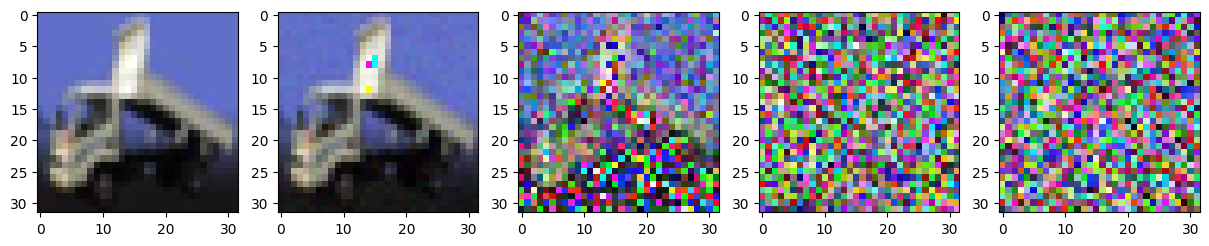

In [16]:
# Simulate forward diffusion
img = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
timesteps = [5, 100, 400, 700, 999]
for i, timestep in enumerate(timesteps):
    plt.subplot(1, len(timesteps), i + 1)
    show_tensor_image(img)
    t = torch.Tensor([timestep]).type(torch.int64)
    img, noise = forward_diffusion_sample(img, t)

In [29]:
@torch.no_grad()
def sample_plot_image(model):
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(model, img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show() 

In [30]:
import os
def get_or_load_model(device, use_checkpoint=True):
    model = SimpleUnet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    curr_epoch = 0
    if use_checkpoint and os.path.exists('model.pt'):
        checkpoint = torch.load('model.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        curr_epoch = checkpoint['curr_epoch']
    return model, optimizer, curr_epoch

def train(model, optimizer, num_epochs, curr_epoch=0):
    from tqdm import tqdm

    while curr_epoch < num_epochs:
        # Initialize tqdm progress bar
        with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {curr_epoch}") as pbar:
            for step, (x, _) in pbar:
                x = x.to(device)
                model.train()
                t = torch.randint(0, T, (x.shape[0],), device=device)
                optimizer.zero_grad()
                loss = get_loss(model, x, t)
                loss.backward()
                optimizer.step()
                # Update the progress bar with the current loss
                pbar.set_postfix({'Loss': loss.item()})
        # Optionally, plot an image sample after each epoch
        curr_epoch += 1
        sample_plot_image(model)
    return curr_epoch

model, optimizer, curr_epoch = get_or_load_model(device)
curr_epoch = train(model, optimizer, 50, curr_epoch=curr_epoch)

# Save the model and optimizer state dicts
torch.save({
    'curr_epoch': curr_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model.pt')

TypeError: sample_timestep() takes 2 positional arguments but 3 were given

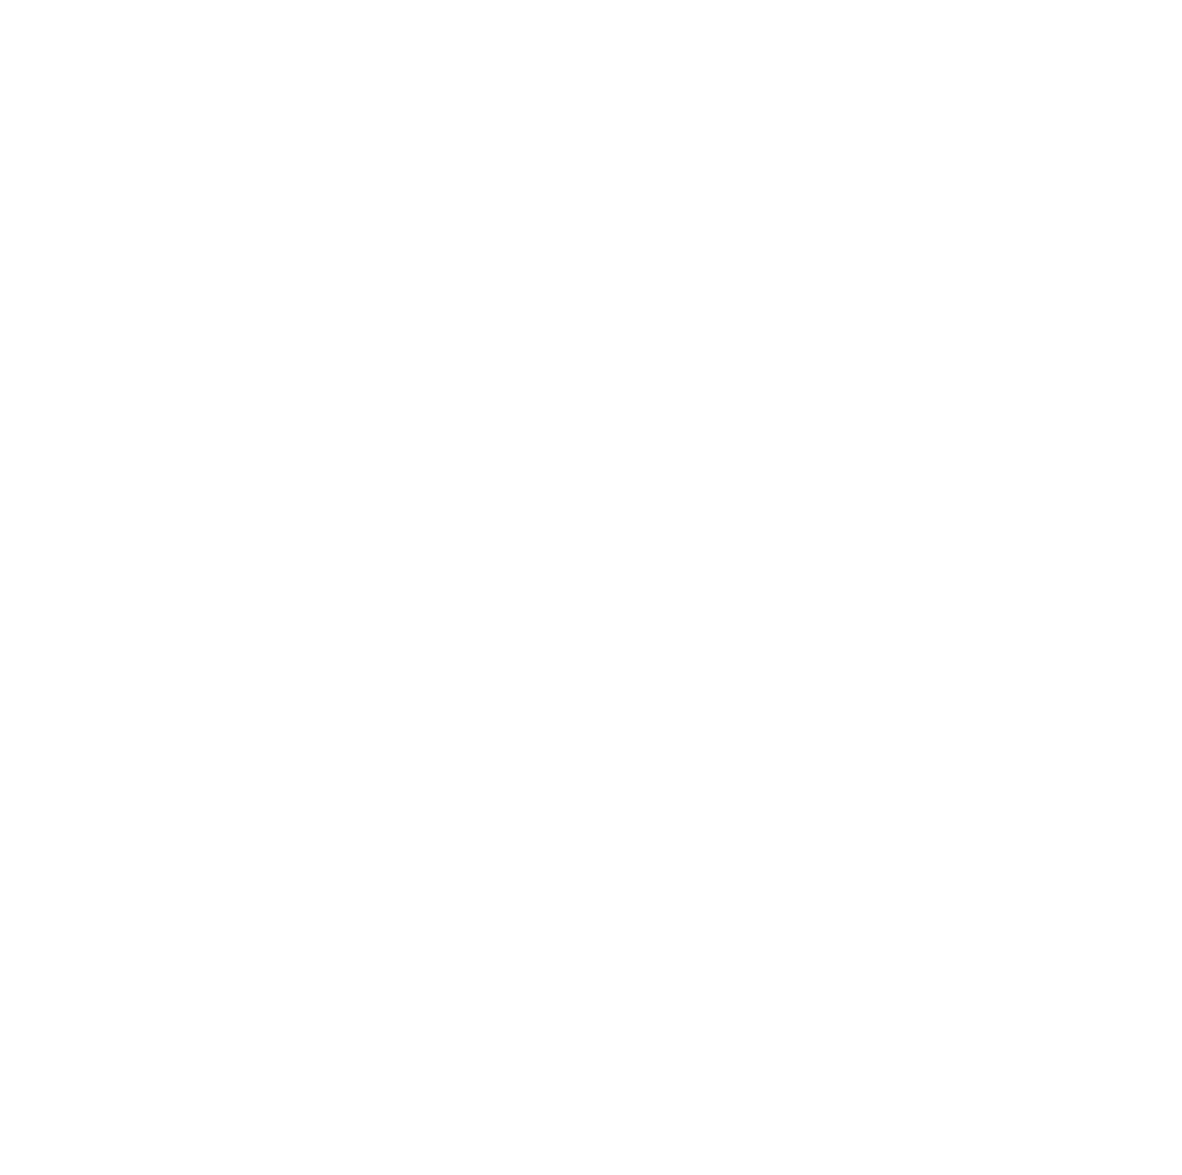

In [31]:
sample_plot_image(model)